# 3.1 Regression: Salary Prediction with RAPIDS cuML

This notebook predicts job salary using various feature sets and RAPIDS cuML models.

## RAPIDS Environment Assertion

In [1]:
import os
assert os.environ.get("RAPIDS_NO_INITIALIZE") is None, "Make sure you're using the RAPIDS Kaggle Docker image, GPU T4 as accelerator"
!nvidia-smi

Fri May 16 13:03:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Libraries Required

In [2]:
import joblib
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import load_npz, hstack

from cuml.linear_model import Ridge, Lasso
from cuml.metrics import mean_squared_error
from cuml.neighbors import KNeighborsRegressor
from cuml.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

## Data Loading

In [3]:
# Data Loading
train_df = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/train_data.parquet')
dev_df   = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/dev_data.parquet')
test_df  = pd.read_parquet('/kaggle/input/ds-preprocessing-output-files/test_data.parquet')

X_train_emb = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_train.npy')
X_dev_emb   = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_dev.npy')
X_test_emb  = np.load('/kaggle/input/ds-preprocessing-output-files/fused_emb_test.npy')

X_train_skills = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_train.npz')
X_dev_skills   = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_dev.npz')
X_test_skills  = load_npz('/kaggle/input/ds-preprocessing-output-files/skills_tfidf_test.npz')

y_train = train_df['salary_avg'].values
y_dev   = dev_df['salary_avg'].values
y_test  = test_df['salary_avg'].values

drop_cols = ['Job Title_encoded', 'salary_avg']
X_train_struct = train_df.drop(columns=drop_cols).values
X_dev_struct   = dev_df.drop(columns=drop_cols).values
X_test_struct  = test_df.drop(columns=drop_cols).values

del dev_df, test_df
gc.collect();

## Ridge Regression - Feature Importance for Structured Features

- We will use cuML's Ridge regression coefficients as a proxy for feature importance.

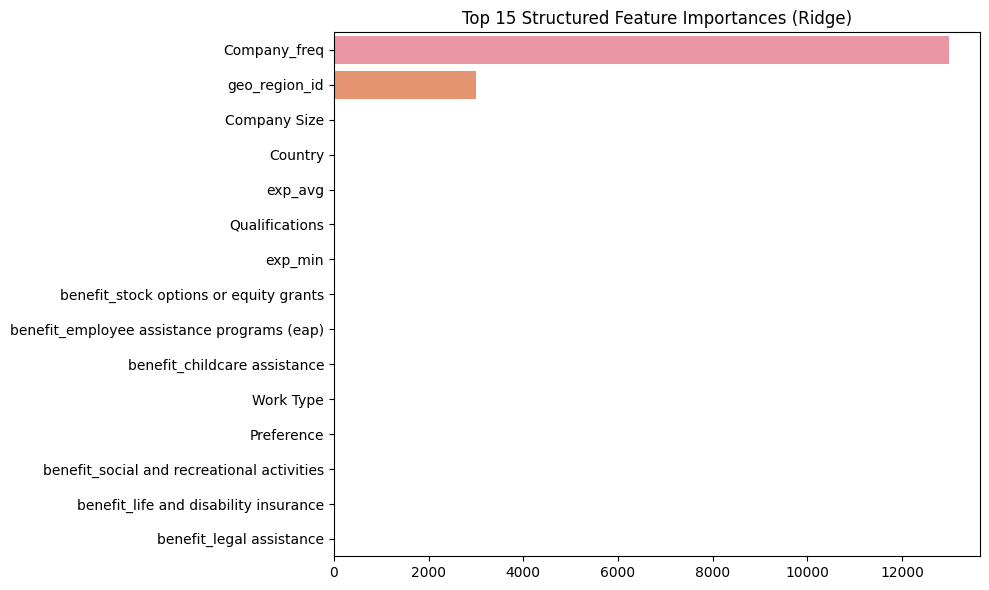

Company_freq                                  12999.964142
geo_region_id                                  2999.990480
Company Size                                      0.000087
Country                                           0.000087
exp_avg                                           0.000065
Qualifications                                    0.000058
exp_min                                           0.000038
benefit_stock options or equity grants            0.000036
benefit_employee assistance programs (eap)        0.000036
benefit_childcare assistance                      0.000033
Work Type                                         0.000033
Preference                                        0.000032
benefit_social and recreational activities        0.000029
benefit_life and disability insurance             0.000029
benefit_legal assistance                          0.000028
salary_max                                        0.000026
benefit_financial counseling                      0.0000

In [4]:
# Ridge Regression for feature importance
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_struct, y_train)
coefs = ridge.coef_.get() if hasattr(ridge.coef_, 'get') else ridge.coef_

feature_names = train_df.drop(columns=drop_cols).columns
feat_imp = pd.Series(np.abs(coefs), index=feature_names).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values[:15], y=feat_imp.index[:15])
plt.title('Top 15 Structured Feature Importances (Ridge)')
plt.tight_layout()
plt.show()

feat_imp

## Trying Different Feature (X) Combinations

- We'll compare Ridge model trained on: structured only, embeddings only, skills only, and a mix of them.

In [5]:
combos = {
    'structured': X_train_struct,
    'fused SBERT embeddings': X_train_emb,
    'tfidf embeddings': X_train_skills.toarray(),
    'str+emb': np.hstack([X_train_struct, X_train_skills.toarray()])
}
dev_combos = {
    'structured': X_dev_struct,
    'fused SBERT embeddings': X_dev_emb,
    'tfidf embeddings': X_dev_skills.toarray(),
    'str+emb': np.hstack([X_dev_struct, X_dev_skills.toarray()])
}
results = {}
for name, Xtr in combos.items():
    print(f'Training Ridge Regression on {name} features...')
    model = Ridge(alpha=0.1)
    model.fit(Xtr, y_train)
    y_pred = model.predict(dev_combos[name])
    mse = mean_squared_error(y_dev, y_pred)
    rmse = np.sqrt(mse)
    y_min, y_max = np.min(y_dev), np.max(y_dev)
    normalized_rmse = rmse / (y_max - y_min)
    results[name] = normalized_rmse.astype(np.float16)
    print(f'RMSE: {normalized_rmse:.2f}\t range:[0-1] closer to 0 the better. \n')
    del Xtr, model
    gc.collect();

results

Training Ridge Regression on structured features...
RMSE: 0.00	 range:[0-1] closer to 0 the better. 

Training Ridge Regression on fused SBERT embeddings features...
RMSE: 0.25	 range:[0-1] closer to 0 the better. 

Training Ridge Regression on tfidf embeddings features...
RMSE: 0.25	 range:[0-1] closer to 0 the better. 

Training Ridge Regression on str+emb features...
RMSE: 0.00	 range:[0-1] closer to 0 the better. 



{'structured': 6e-08,
 'fused SBERT embeddings': 0.251,
 'tfidf embeddings': 0.251,
 'str+emb': 6e-08}

## Final Ridge Model: Tuning and Evaluating on Test Set

We'll use the best feature combo and tune the model.

In [6]:
best_combo = min(results, key=results.get)
print(f'Best feature set: {best_combo}')
Xtr = combos[best_combo]
Xdev = dev_combos[best_combo]
Xte = np.hstack([X_test_struct, X_test_emb, X_test_skills.toarray()]) if best_combo == 'str+emb' else (
    X_test_struct if best_combo == 'structured' else (
        X_test_emb if best_combo == 'fused SBERT embeddings' else X_test_skills.toarray()
    )
)

# Hyperparameter tuning (alpha)
best_rmse = float('inf')
best_alpha = 1.0
for alpha in [0.1, 1.0, 10.0, 100.0]:
    model = Ridge(alpha=alpha)
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xdev)
    rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha
print(f'Best alpha: {best_alpha}, Dev RMSE: {best_rmse:.2f}')

Best feature set: structured
Best alpha: 0.1, Dev RMSE: 0.00


In [7]:
# Train on train+dev, evaluate on test
X_train_full = np.vstack([Xtr, Xdev])
y_train_full = np.concatenate([y_train, y_dev])
model = Ridge(alpha=best_alpha)
model.fit(X_train_full, y_train_full)
y_test_pred = model.predict(Xte)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f'Test RMSE: {test_rmse:.2f}')

# Save model
joblib.dump(model, '/kaggle/working/ridge_regression_cuml.joblib')

Test RMSE: 0.00


['/kaggle/working/ridge_regression_cuml.joblib']

## Visual: True vs. Predicted Salary (Test Set)

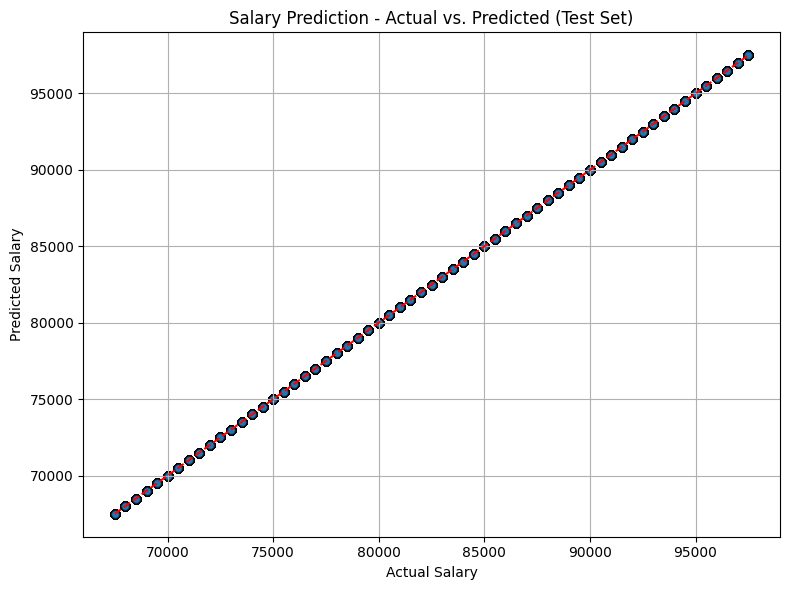

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.2, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Prediction - Actual vs. Predicted (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 2nd Model: K Neighbors Regressor

### Training then Evaluating on Dev Set

In [9]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(Xtr, y_train)
y_pred = model.predict(Xdev)
rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
y_min, y_max = np.min(y_dev), np.max(y_dev)
normalized_rmse = rmse / (y_max - y_min)
print(f'KNN RMSE: {rmse:.4f}, Normalized RMSE [0-1]: {normalized_rmse:.4f}')

KNN RMSE: 1923.8775, Normalized RMSE [0-1]: 0.0641


### Visual: True vs. Predicted Salary (Dev Set)

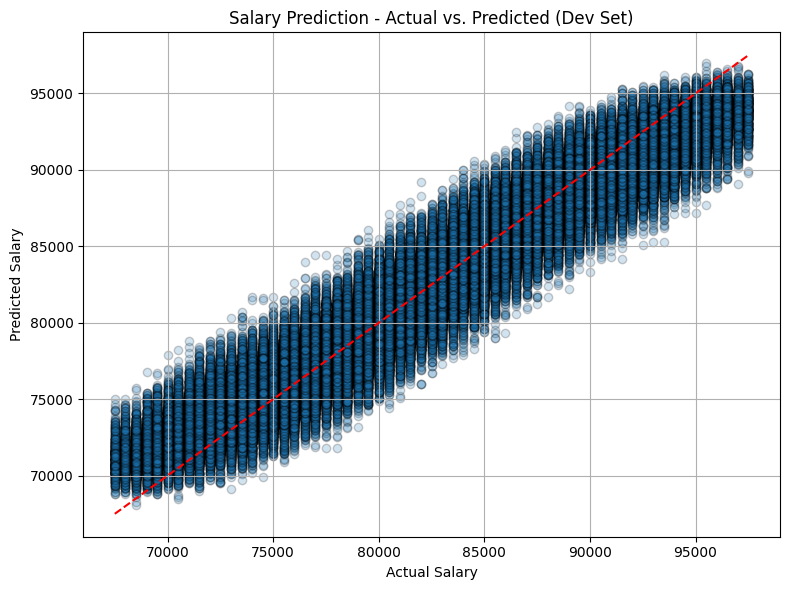

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(y_dev, y_pred, alpha=0.2, edgecolors='k')
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Prediction - Actual vs. Predicted (Dev Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Visual: Permutation Importance

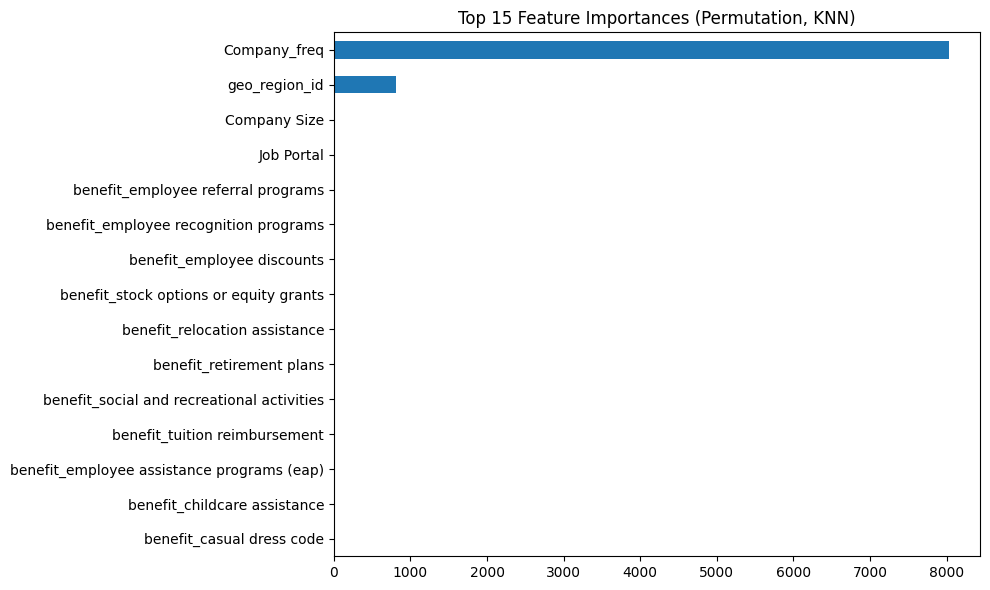

Company_freq                                  8032.899822
geo_region_id                                  816.505612
Company Size                                     5.817318
Job Portal                                       0.247390
benefit_employee referral programs               0.000000
benefit_employee recognition programs            0.000000
benefit_employee discounts                       0.000000
benefit_stock options or equity grants           0.000000
benefit_relocation assistance                    0.000000
benefit_retirement plans                         0.000000
benefit_social and recreational activities       0.000000
benefit_tuition reimbursement                    0.000000
benefit_employee assistance programs (eap)       0.000000
benefit_childcare assistance                     0.000000
benefit_casual dress code                        0.000000
benefit_financial counseling                     0.000000
benefit_flexible spending accounts (fsas)        0.000000
benefit_parent

In [11]:
idx = np.random.choice(len(y_dev), size=1000, replace=False)
Xdev_sub = Xdev[idx]
y_dev_sub = y_dev[idx]

result = permutation_importance(
    model, Xdev_sub, y_dev_sub, n_repeats=3, random_state=42, scoring='neg_root_mean_squared_error'
)

importances = pd.Series(result.importances_mean, index=feature_names)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances[:15].plot(kind='barh')
plt.title('Top 15 Feature Importances (Permutation, KNN)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importances

## 3rd Model: SVM Regressor (SVR)

### Training then Evaluating on Dev Set

In [12]:
model = SVR(C=1.0, kernel='rbf')
model.fit(Xtr, y_train)
y_pred = model.predict(Xdev)
rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
y_min, y_max = np.min(y_dev), np.max(y_dev)
normalized_rmse = rmse / (y_max - y_min)
print(f'SVR RMSE: {rmse:.4f}, Normalized RMSE [0-1]: {normalized_rmse:.4f}')

SVR RMSE: 1302.6539, Normalized RMSE [0-1]: 0.0434


### Visual: True vs. Predicted Salary (Dev Set)

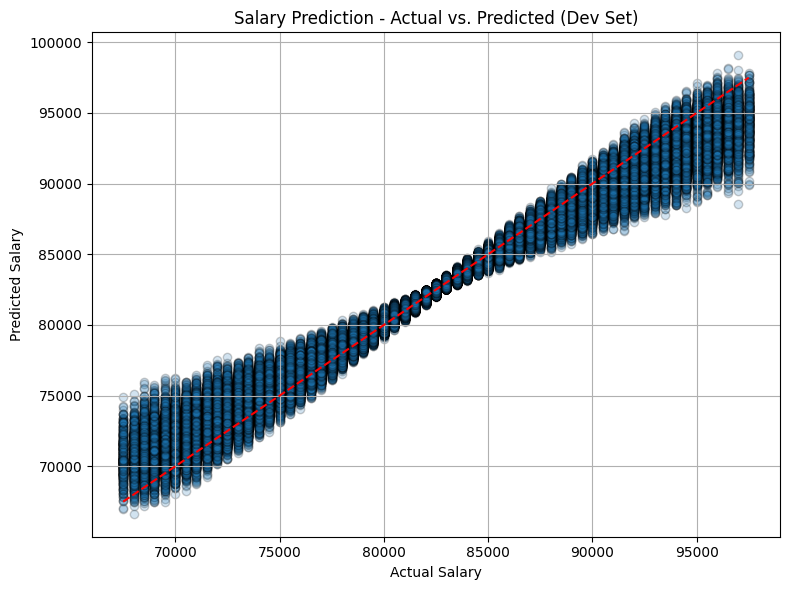

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(y_dev, y_pred, alpha=0.2, edgecolors='k')
plt.plot([y_dev.min(), y_dev.max()], [y_dev.min(), y_dev.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Salary Prediction - Actual vs. Predicted (Dev Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Visual: Permutation Importance 

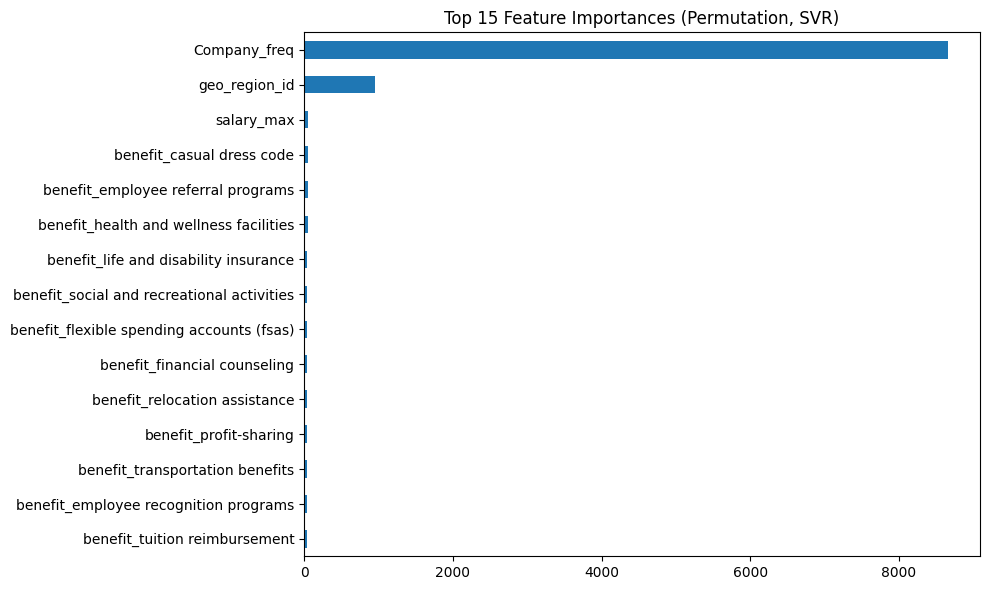

Company_freq                                  8657.534795
geo_region_id                                  955.069574
salary_max                                      47.850301
benefit_casual dress code                       47.707128
benefit_employee referral programs              47.707128
benefit_health and wellness facilities          47.707128
benefit_life and disability insurance           40.862660
benefit_social and recreational activities      40.862660
benefit_flexible spending accounts (fsas)       40.433344
benefit_financial counseling                    40.433344
benefit_relocation assistance                   38.349028
benefit_profit-sharing                          37.434069
benefit_transportation benefits                 37.434069
benefit_employee recognition programs           36.299281
benefit_tuition reimbursement                   35.337070
benefit_parental leave                          35.337070
benefit_legal assistance                        34.886384
benefit_profes

In [14]:
result = permutation_importance(
    model, Xdev_sub, y_dev_sub, n_repeats=3, random_state=42, scoring='neg_root_mean_squared_error'
)

# Display top features
importances = pd.Series(result.importances_mean, index=feature_names)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances[:15].plot(kind='barh')
plt.title('Top 15 Feature Importances (Permutation, SVR)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

importances